<a href="https://colab.research.google.com/github/hyulianton/BigData/blob/main/Exploratory_Data_Analysis_(EDA)_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Selecting previously unselected package libxtst6:amd64.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u452-ga~us1-0ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u452-ga~us1-0ubuntu1~22.04) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.
Preparing to unpack .../openjdk-8-jdk-headless_8u452-ga~us1-0ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-8-jdk-headless:amd64 (8u452-ga~us1-0ubuntu1~22.04) ...
Setting up libxtst6:amd64 (2:1.2.3-1build4) ...
Setting up openjdk-8-jre-headless:amd64 (8u452-ga~us1-0ubuntu1~22.04) ...
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/orbd to provide /usr/bin/orbd (orbd) in auto mode
update-alternatives: using /usr/lib/jvm/java-8-openjdk

In [2]:
!wget https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz

--2025-05-10 13:56:47--  https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 88.99.208.237, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400724056 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.5-bin-hadoop3.tgz’

spark-3.5.5-bin-had 100%[===================>] 382.16M  24.1MB/s    in 17s     

2025-05-10 13:57:04 (22.3 MB/s) - ‘spark-3.5.5-bin-hadoop3.tgz’ saved [400724056/400724056]



In [4]:
!tar -xf spark-3.5.5-bin-hadoop3.tgz

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"

In [6]:
!pip install findspark
!pip install pyspark

Karena dataset dari scikit-learn terlalu kecil untuk didemonstrasikan dengan Spark (yang dirancang untuk data yang tidak muat di satu mesin), kita akan:
1.  Buat dataset sintetis yang ukurannya *lebih besar* (dengan mereplikasi data scikit-learn berkali-kali).
2.  Simpan dataset sintetis ini ke format Parquet, yang merupakan format umum dan efisien untuk Big Data di ekosistem Spark.
3.  Baca data dari file Parquet ini ke dalam Spark DataFrame.
4.  Demonstrasikan operasi EDA menggunakan Spark DataFrame API dan Spark SQL.
5.  Jelaskan bagaimana visualisasi biasanya dilakukan *setelah* Spark melakukan agregasi atau sampling.

Pastikan Anda sudah menginstal PySpark (`pip install pyspark pandas numpy scikit-learn`) dan memiliki Spark yang dapat diakses.

In [7]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
import random
import os # Untuk menyimpan file lokal

# Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, floor, avg, stddev, percentile_approx, corr
from pyspark.sql.types import DoubleType # Untuk simulasi missing values

# --- Inisialisasi Spark Session ---
# Ini adalah titik masuk untuk menggunakan fungsionalitas Spark
print("Menginisialisasi Spark Session...")
spark = SparkSession.builder \
    .appName("BigData_EDA_Spark_Example") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark Session berhasil diinisialisasi.")

# --- Buat Dataset Sintetis Skala Lebih Besar ---
# Dataset scikit-learn terlalu kecil. Kita buat versi "Big Data" dengan replikasi.
# Dalam skenario nyata, data Anda sudah dalam format Big Data di HDFS/S3/dll.
print("\nMembuat dataset sintetis yang lebih besar (dengan mereplikasi data diabetes)...")
diabetes = load_diabetes()
data_small_pandas = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
target_small_pandas = pd.DataFrame(diabetes.target, columns=['target'])
df_small_pandas = pd.concat([data_small_pandas, target_small_pandas], axis=1)

# Replikasi data berkali-kali untuk mensimulasikan ukuran besar
replication_factor = 10000 # Dataset asli 442 baris -> 4.42 juta baris
df_large_pandas = pd.concat([df_small_pandas] * replication_factor, ignore_index=True)

# Tambahkan missing values (simulasi)
print("Mensimulasikan missing values di dataset sintetis...")
for col_name in ['bmi', 'bp', 's1', 'target']:
    # Ambil indeks acak sebanyak 1% dari total baris
    missing_indices = np.random.choice(df_large_pandas.index, size=int(len(df_large_pandas) * 0.01), replace=False)
    df_large_pandas.loc[missing_indices, col_name] = np.nan

# Simpan ke file Parquet
parquet_path = "./synthetic_diabetes.parquet"
print(f"Menyimpan dataset sintetis ke {parquet_path}...")
df_large_pandas.to_parquet(parquet_path)

print(f"Dataset sintetis ({len(df_large_pandas)} baris) berhasil dibuat dan disimpan.")

# --- Load Data ke Spark DataFrame ---
# Ini adalah cara membaca data Big Data ke Spark
print(f"\nMemuat dataset dari file Parquet ({parquet_path}) ke Spark DataFrame...")
spark_df = spark.read.parquet(parquet_path)

print("\nSpark DataFrame berhasil dimuat.")
#spark_df.printSchema() # Bisa cek skema Spark
spark_df.show(5) # Tampilkan 5 baris pertama (diambil dari partisi manapun, hanya sampel)
print(f"Total baris di Spark DataFrame (dihitung terdistribusi): {spark_df.count()}")

# Hapus file lokal sintetis jika tidak lagi diperlukan
# os.remove(parquet_path) # Opsional: Hapus setelah dibaca
# os.remove(parquet_path + "/_SUCCESS") # Jika Spark menulis file _SUCCESS

Menginisialisasi Spark Session...
Spark Session berhasil diinisialisasi.

Membuat dataset sintetis yang lebih besar (dengan mereplikasi data diabetes)...
Mensimulasikan missing values di dataset sintetis...
Menyimpan dataset sintetis ke ./synthetic_diabetes.parquet...
Dataset sintetis (4420000 baris) berhasil dibuat dan disimpan.

Memuat dataset dari file Parquet (./synthetic_diabetes.parquet) ke Spark DataFrame...

Spark DataFrame berhasil dimuat.
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+
|                 age|                 sex|                 bmi|                  bp|                  s1|                  s2|                  s3|                  s4|                  s5|                  s6|target|
+--------------------+--------------------+--------------------+--------------------+--------------------+---

---

**Contoh Program 1: Ringkasan Statistik Dasar (Menggunakan Spark DataFrame)**

Kita akan menghitung statistik deskriptif pada *seluruh* Spark DataFrame yang (secara konseptual) berukuran besar.

In [8]:
print("\n--- Contoh 1: Ringkasan Statistik Dasar (Spark DataFrame di Data Terdistribusi) ---")

# Menggunakan .describe() atau .summary() pada Spark DataFrame
# Ini menghitung statistik secara terdistribusi.
print("\nStatistik deskriptif kolom numerik (Spark DataFrame .describe()):")
spark_df.describe(['bmi', 'bp', 'target']).show()

# .summary() memberikan statistik yang lebih kaya, termasuk persentil (aproksimasi)
print("\nRingkasan statistik (Spark DataFrame .summary()):")
spark_df.summary().show()

# Menghitung statistik spesifik menggunakan Spark SQL functions
# Ini dieksekusi secara terdistribusi di seluruh klaster.
# Untuk median/percentile, gunakan percentile_approx untuk efisiensi di Big Data
print(f"\nRata-rata BMI (Spark): {spark_df.select(avg('bmi')).collect()[0][0]:.2f}") # collect() mengambil hasil ke driver
print(f"Standard Deviasi Tekanan Darah (Spark): {spark_df.select(stddev('bp')).collect()[0][0]:.2f}")

# Menghitung Median (Percentil ke-50) dan Percentil ke-75 secara aproksimasi di Spark
# percentile_approx(column, percentage, accuracy - optional)
approx_quantiles_target = spark_df.stat.approxQuantile('target', [0.5, 0.75], 0.01) # akurasi 0.01
median_target_spark = approx_quantiles_target[0]
q3_target_spark = approx_quantiles_target[1]

print(f"Median Target (Spark, aproksimasi): {median_target_spark:.2f}")
print(f"Percentil ke-75 Target (Spark, aproksimasi): {q3_target_spark:.2f}")

# Untuk menghitung modus (nilai paling sering) per kolom di Spark
# spark_df.groupBy("nama_kolom_kategori").count().orderBy(col("count").desc()).show()


--- Contoh 1: Ringkasan Statistik Dasar (Spark DataFrame di Data Terdistribusi) ---

Statistik deskriptif kolom numerik (Spark DataFrame .describe()):
+-------+--------------------+--------------------+------------------+
|summary|                 bmi|                  bp|            target|
+-------+--------------------+--------------------+------------------+
|  count|             4375800|             4375800|           4375800|
|   mean|-1.44314204073557...|-3.06722789341444...|152.13737830796654|
| stddev|0.047564388061949896|0.047562564417359475| 77.00644191341371|
|    min|-0.09027529589850945|-0.11239880254408448|              25.0|
|    max| 0.17055522598064407| 0.13204361674121307|             346.0|
+-------+--------------------+--------------------+------------------+


Ringkasan statistik (Spark DataFrame .summary()):
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-

---

**Contoh Program 2: Visualisasi Distribusi Data (Menggunakan Spark untuk Agregasi, Visualisasi di Luar)**

Spark digunakan untuk menghitung data yang dibutuhkan untuk visualisasi (misalnya, jumlah per bin untuk histogram). Visualisasi *itu sendiri* biasanya dilakukan menggunakan library lain (Pandas/Matplotlib/Seaborn) setelah mengumpulkan data ringkasan, atau menggunakan tool BI yang terhubung ke Spark.


--- Contoh 2: Visualisasi Distribusi Data (Spark untuk Agregasi, Visualisasi di Luar) ---

Melakukan grouping berdasarkan kolom bin yang baru dibuat...

Data agregasi per bin untuk Histogram BMI (Spark):
+-------+-------+
|bmi_bin|count  |
+-------+-------+
|NULL   |44200  |
|-0.05  |613784 |
|0.0    |3039325|
|0.05   |603951 |
|0.1    |98925  |
+-------+-------+
only showing top 5 rows


Mengumpulkan hasil agregasi ke Pandas (Spark .toPandas())...


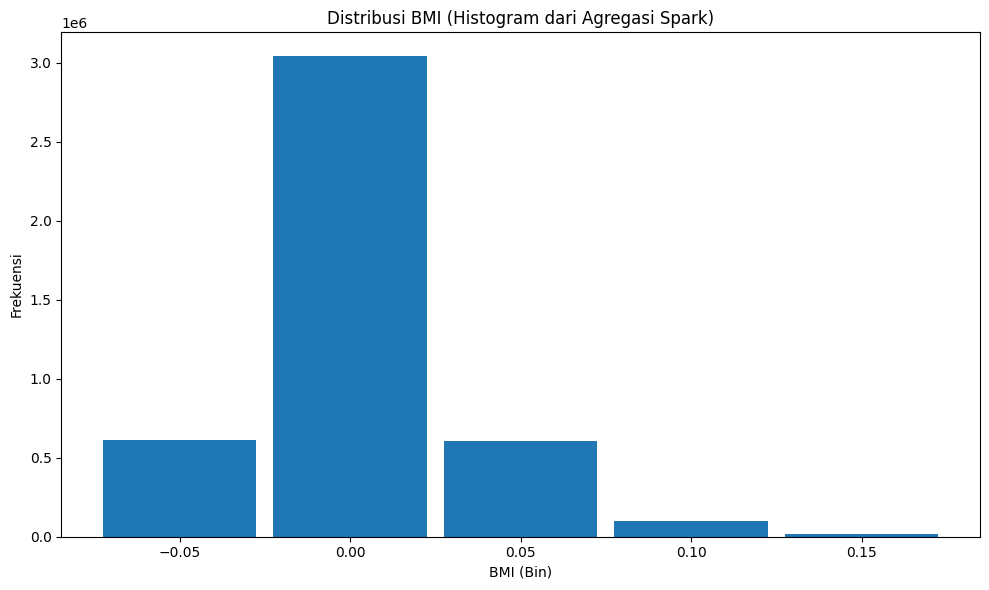

In [12]:
print("\n--- Contoh 2: Visualisasi Distribusi Data (Spark untuk Agregasi, Visualisasi di Luar) ---")

# Membuat data untuk Histogram 'bmi' menggunakan Agregasi di Spark
# Tentukan ukuran bin
bin_size = 0.05 # Ukuran bin sebagai float Python

# Import lit function (pastikan sudah diimpor di bagian atas program)
# from pyspark.sql.functions import lit, col, floor # atau cast

# Langkah Perbaikan Terakhir: Hitung nilai bin sebagai kolom baru terlebih dahulu
# Menggunakan pendekatan .cast("int")
spark_df_with_bins = spark_df.withColumn(
    "bmi_bin",
    (col("bmi")/lit(bin_size)).cast("int") * lit(bin_size)
)

# Atau jika ingin coba lagi dengan floor() sebagai alternatif untuk nilai bin
# spark_df_with_bins = spark_df.withColumn(
#     "bmi_bin",
#     floor(col("bmi")/lit(bin_size)) * lit(bin_size)
# )


# Sekarang, lakukan grouping berdasarkan nama kolom baru "bmi_bin"
print("\nMelakukan grouping berdasarkan kolom bin yang baru dibuat...")
bmi_hist_spark = spark_df_with_bins.groupBy("bmi_bin").count().orderBy("bmi_bin") # Urutkan berdasarkan bin itu sendiri untuk plot

print("\nData agregasi per bin untuk Histogram BMI (Spark):")
# Menggunakan .show(n=n, truncate=False) agar nilai bin yang diplot tidak terpotong jika terlalu panjang
# Nama kolom bin sekarang seharusnya "bmi_bin"
bmi_hist_spark.show(5, truncate=False)

# Mengumpulkan HASIL AGREGASI ke Pandas untuk Visualisasi
# HATI-HATI: Gunakan .toPandas() hanya jika hasil agregasi CUKUP KECIL
print("\nMengumpulkan hasil agregasi ke Pandas (Spark .toPandas())...")
try:
    bmi_hist_pandas = bmi_hist_spark.toPandas()

    # Visualisasi Histogram menggunakan Matplotlib/Seaborn pada data yang sudah diagregasi
    plt.figure(figsize=(10, 6))
    # Nama kolom bin di Pandas DataFrame hasil .toPandas() akan sesuai dengan nama kolom baru di Spark
    plt.bar(bmi_hist_pandas["bmi_bin"], bmi_hist_pandas['count'], width=bin_size * 0.9)
    plt.title('Distribusi BMI (Histogram dari Agregasi Spark)')
    plt.xlabel('BMI (Bin)')
    plt.ylabel('Frekuensi')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Gagal mengumpulkan data agregasi ke Pandas karena ukuran terlalu besar atau error: {e}")
    print("Visualisasi langsung dari Spark tidak umum; biasanya pakai tools BI atau library khusus.")
# Visualisasi KDE dari Big Data:
# KDE plot langsung dari seluruh Big Data sangat mahal dan tidak umum.
# Biasanya, KDE dihitung dari SAMPEL data (menggunakan .sample() di Spark, lalu .toPandas() untuk sampelnya)
# atau menggunakan algoritma estimasi densitas yang dirancang untuk skala besar.

# Contoh mendapatkan sampel untuk visualisasi KDE
# spark_df_sample = spark_df.sample(fraction=0.001, seed=42) # Ambil 0.1% sampel
# try:
#     df_sample_pandas_for_kde = spark_df_sample.toPandas()
#     plt.figure(figsize=(8, 6))
#     sns.kdeplot(df_sample_pandas_for_kde['bmi'], fill=True)
#     plt.title('Estimasi Densitas Kernel BMI (dari Sampel Spark)')
#     plt.xlabel('BMI')
#     plt.ylabel('Densitas')
#     plt.show()
# except Exception as e:
#      print(f"Gagal mengumpulkan sampel untuk KDE: {e}")

# --- Koneksi ke Big Data ---
# Tools BI seperti Tableau, Superset, Looker bisa terhubung langsung ke Spark
# dan melakukan operasi agregasi/filter yang diperlukan di backend, lalu memvisualisasikannya.
# Library seperti Datashader (dengan backend Dask atau RAPIDS, bisa diintegrasikan dengan Spark)
# dirancang untuk memvisualisasikan miliaran titik data dengan melakukan rasterisasi (binning ke piksel).

---

**Contoh Program 3: Analisis Missing Values (Menggunakan Spark DataFrame)**

Mengecek dan menangani missing values dilakukan menggunakan operasi Spark DataFrame yang berjalan terdistribusi.

In [13]:
print("\n--- Contoh 3: Analisis Missing Values (Spark DataFrame di Data Terdistribusi) ---")

# Mengecek jumlah missing values per kolom di SELURUH Spark DataFrame
# Menggunakan fungsi agregasi COUNT() dengan kondisi IS NULL atau ISNAN
print("\nJumlah missing values per kolom di Spark DataFrame:")

# Cara 1: Menggunakan SQL Expression string di select
# requires `from pyspark.sql.functions import expr` if not already imported
# spark_df.select([expr(f"count(CASE WHEN {c} IS NULL THEN 1 END)").alias(c + "_missing") for c in spark_df.columns]).show()

# Cara 2: Menggunakan DataFrame functions (lebih PySparkic)
# requires `from pyspark.sql.functions import col, count, when, isnan`
missing_counts = spark_df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c + "_missing") for c in spark_df.columns])
missing_counts.show()

# Menangani missing values di Spark DataFrame:
# .na.drop() untuk menghapus baris dengan missing values
# Menghapus di Big Data berpotensi kehilangan banyak data jika tidak hati-hati
print("\nSpark DataFrame setelah menghapus baris dengan missing BMI:")
spark_df_dropped = spark_df.na.drop(subset=['bmi'])
print(f"Jumlah baris setelah menghapus baris dengan missing BMI (dihitung terdistribusi): {spark_df_dropped.count()} (dari {spark_df.count()})")
spark_df_dropped.show(5) # Tampilkan sampel hasilnya

# .na.fill() untuk mengisi missing values
# Rata-rata (atau nilai pengisi lain) harus dihitung dari data asli (jika perlu)
# Hitung rata-rata BMI dari data ASLI (bukan sampel atau data yang sudah dihapus missingnya jika itu bukan tujuan)
mean_bmi_spark = spark_df.select(avg('bmi')).collect()[0][0]
print(f"\nRata-rata BMI dari seluruh Spark DataFrame: {mean_bmi_spark:.2f}")

# Isi missing BMI dengan rata-rata yang dihitung secara terdistribusi
spark_df_filled = spark_df.na.fill({'bmi': mean_bmi_spark})
print("\nSpark DataFrame setelah mengisi missing BMI dengan rata-rata:")
# Cek lagi missing count untuk BMI - seharusnya 0
spark_df_filled.select(count(when(col("bmi").isNull() | isnan(col("bmi")), "bmi")).alias("bmi_missing")).show()
spark_df_filled.show(5) # Tampilkan sampel hasilnya

# --- Koneksi ke Big Data ---
# Pola missingness (heatmap) visualisasi langsung dari Spark DataFrame mentah berukuran besar sulit.
# Biasanya dicek dari hitungan missing per kolom seperti di atas, atau dicek di sampel data.


--- Contoh 3: Analisis Missing Values (Spark DataFrame di Data Terdistribusi) ---

Jumlah missing values per kolom di Spark DataFrame:
+-----------+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+--------------+
|age_missing|sex_missing|bmi_missing|bp_missing|s1_missing|s2_missing|s3_missing|s4_missing|s5_missing|s6_missing|target_missing|
+-----------+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+--------------+
|          0|          0|      44200|     44200|     44200|         0|         0|         0|         0|         0|         44200|
+-----------+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+--------------+


Spark DataFrame setelah menghapus baris dengan missing BMI:
Jumlah baris setelah menghapus baris dengan missing BMI (dihitung terdistribusi): 4375800 (dari 4420000)
+--------------------+--------------------+----

---

**Contoh Program 4: Analisis Hubungan (Korelasi Menggunakan Spark DataFrame)**

Spark dapat menghitung korelasi antar kolom atau matriks korelasi secara terdistribusi.

In [16]:
print("\n--- Contoh 4: Analisis Hubungan (Korelasi di Spark DataFrame) ---")

# Menghitung Korelasi antar dua kolom spesifik di SELURUH Spark DataFrame
# Menggunakan .stat.corr(col1, col2) atau .corr(col1, col2)
# Kedua sintaks ini biasanya sinonim dan bekerja untuk pasangan kolom.
correlation_bmi_target = spark_df.stat.corr("bmi", "target")
print(f"\nKorelasi Pearson antara BMI dan Target (Spark): {correlation_bmi_target:.2f}")

# Hitung korelasi untuk beberapa pasangan lain yang menarik di dataset ini
correlation_bmi_bp = spark_df.stat.corr("bmi", "bp")
correlation_s1_s2 = spark_df.stat.corr("s1", "s2")
correlation_target_bp = spark_df.stat.corr("target", "bp")


print(f"Korelasi Pearson antara BMI dan Tekanan Darah (Spark): {correlation_bmi_bp:.2f}")
print(f"Korelasi Pearson antara S1 dan S2 (Spark): {correlation_s1_s2:.2f}")
print(f"Korelasi Pearson antara Target dan Tekanan Darah (Spark): {correlation_target_bp:.2f}")


# --- Menghitung Matriks Korelasi Antar SEMUA Fitur (Penjelasan Konseptual & Kendala) ---
print("\n--- Matriks Korelasi Antar SEMUA Fitur (Penjelasan Kendala di Versi PySpark Ini) ---")
print("Menghitung matriks korelasi penuh antar semua kolom numerik menggunakan spark_df.corr() tanpa argumen")
print("menyebabkan error di versi PySpark ini karena fungsi tersebut mengharapkan 2 argumen kolom.")
print("Menghitung matriks korelasi penuh memerlukan pendekatan yang berbeda:")

print("1. Pendekatan Iteratif (Kurang Efisien untuk Banyak Kolom):")
print("   Melakukan loop untuk setiap pasangan kolom (col_i, col_j), memanggil spark_df.stat.corr(col_i, col_j),")
print("   dan mengumpulkan hasilnya untuk membangun matriks Pandas secara manual.")
print("   Ini membutuhkan banyak job Spark terpisah.")
# Contoh Kode Konseptual (tidak runnable sepenuhnya di sini tanpa logic loop lengkap & error handling):
# numeric_cols = [c for c, dtype in spark_df.dtypes if dtype in ['double', 'float', 'int', 'long']]
# # Pastikan tidak ada NaN yang bisa menyebabkan error pada corr() - mungkin perlu .na.drop() sementara
# df_for_corr = spark_df.na.drop(subset=numeric_cols) # Drop baris dengan NaN di kolom numerik untuk korelasi
# corr_data = []
# for i in range(len(numeric_cols)):
#     for j in range(i, len(numeric_cols)): # Hanya hitung segitiga atas
#         col1 = numeric_cols[i]
#         col2 = numeric_cols[j]
#         # Hitung korelasi (ini memicu job Spark)
#         correlation_value = df_for_corr.stat.corr(col1, col2)
#         corr_data.append(((col1, col2), correlation_value))
# # Dari corr_data, bangun matriks Pandas

print("\n2. Pendekatan Menggunakan spark.ml.stat.Correlation (Lebih Scalable, Tapi Perlu Feature Vector):")
print("   Menggunakan modul PySpark MLlib (pyspark.ml.stat.Correlation).")
print("   Ini adalah cara yang lebih skalabel, tetapi membutuhkan langkah tambahan:")
print("   - Menggabungkan semua kolom fitur numerik menjadi satu kolom 'Vector' menggunakan VectorAssembler.")
print("   - Memanggil Correlation.corr() pada DataFrame dengan kolom Vector tersebut.")
# Contoh Kode Konseptual (perlu import VectorAssembler dan Correlation):
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.stat import Correlation
# # Pilih kolom numerik
# numeric_cols_ml = [c for c, dtype in spark_df.dtypes if dtype in ['double', 'float', 'int', 'long']] # Sesuaikan jika ada tipe lain
# # Assembler untuk menggabungkan fitur
# assembler = VectorAssembler(inputCols=numeric_cols_ml, outputCol="features")
# df_vector = assembler.transform(spark_df.na.drop(subset=numeric_cols_ml)) # Drop NaN untuk korelasi

# # Hitung matriks korelasi Pearson pada kolom fitur vector
# matrix = Correlation.corr(df_vector, "features", method="pearson")

# # Hasilnya adalah DataFrame dengan satu baris dan satu kolom Vector.
# # Ambil Vector tersebut dan konversi ke array numpy untuk visualisasi heatmap di Pandas.
# # matrix_np = matrix.collect()[0][0].toArray()
# # matrix_pandas = pd.DataFrame(matrix_np, index=numeric_cols_ml, columns=numeric_cols_ml)
# # Sekarang matrix_pandas bisa divisualisasikan pakai heatmap Seaborn.


print("\n--- Visualisasi Matriks Korelasi (Penjelasan Kendala) ---")
print("Visualisasi heatmap matriks korelasi penuh (MxM) juga punya tantangan:")
print("1. Jika jumlah kolom (M) sangat besar, matriksnya sendiri pun besar (MxM) dan sulit divisualisasikan.")
print("2. Jika matriks berhasil dihitung di Spark (misal pakai MLlib), hasilnya harus dikumpulkan ke driver")
print("   dan diubah ke format (misal Pandas DataFrame) untuk plotting pakai Matplotlib/Seaborn.")
print("   Ini hanya mungkin jika ukuran matriks M x M tidak terlalu besar.")
print("\nUntuk EDA praktis di Big Data, seringkali kita fokus pada:")
print("- Korelasi antar fitur & target variabel saja (subset kolom).")
print("- Menggunakan tools BI yang bisa menghitung agregasi korelasi di backend.")
print("- Melakukan analisis korelasi di SAMPEL data menggunakan Pandas (seperti contoh sebelumnya).")


# Visualisasi Scatter Plot dari Big Data:
# Seperti penjelasan sebelumnya, scatter plot langsung dari seluruh data mentah tidak praktis.
# Lakukan scatter plot pada SAMPEL data (setelah spark_df.sample().toPandas()).
# sns.scatterplot(x='bmi', y='target', data=df_sample_for_pandas) # Gunakan df_sample_for_pandas dari Contoh 6


--- Contoh 4: Analisis Hubungan (Korelasi di Spark DataFrame) ---

Korelasi Pearson antara BMI dan Target (Spark): 0.57
Korelasi Pearson antara BMI dan Tekanan Darah (Spark): 0.39
Korelasi Pearson antara S1 dan S2 (Spark): 0.89
Korelasi Pearson antara Target dan Tekanan Darah (Spark): 0.43

--- Matriks Korelasi Antar SEMUA Fitur (Penjelasan Kendala di Versi PySpark Ini) ---
Menghitung matriks korelasi penuh antar semua kolom numerik menggunakan spark_df.corr() tanpa argumen
menyebabkan error di versi PySpark ini karena fungsi tersebut mengharapkan 2 argumen kolom.
Menghitung matriks korelasi penuh memerlukan pendekatan yang berbeda:
1. Pendekatan Iteratif (Kurang Efisien untuk Banyak Kolom):
   Melakukan loop untuk setiap pasangan kolom (col_i, col_j), memanggil spark_df.stat.corr(col_i, col_j),
   dan mengumpulkan hasilnya untuk membangun matriks Pandas secara manual.
   Ini membutuhkan banyak job Spark terpisah.

2. Pendekatan Menggunakan spark.ml.stat.Correlation (Lebih Scalable, T

---

**Contoh Program 5: Deteksi Outliers (Menggunakan Spark DataFrame)**

Deteksi outliers yang melibatkan perhitungan statistik robust (seperti IQR) atau filtering dilakukan menggunakan Spark DataFrame.

In [17]:
print("\n--- Contoh 5: Deteksi Outliers (Spark DataFrame di Data Terdistribusi) ---")

# Deteksi outlier sederhana berdasarkan ambang batas IQR (Interquartile Range) di Spark
# Perlu menghitung Q1 dan Q3 secara terdistribusi
# Gunakan approxQuantile untuk efisiensi
print("\nMenghitung Q1 dan Q3 untuk BMI secara aproksimasi di Spark...")
try:
    quantiles_bmi_spark = spark_df.stat.approxQuantile('bmi', [0.25, 0.75], 0.01)
    Q1_spark = quantiles_bmi_spark[0]
    Q3_spark = quantiles_bmi_spark[1]
    IQR_spark = Q3_spark - Q1_spark

    outlier_threshold_upper_spark = Q3_spark + 1.5 * IQR_spark
    outlier_threshold_lower_spark = Q1_spark - 1.5 * IQR_spark

    print(f"Q1 BMI (Spark Aproksimasi): {Q1_spark:.2f}")
    print(f"Q3 BMI (Spark Aproksimasi): {Q3_spark:.2f}")
    print(f"IQR BMI: {IQR_spark:.2f}")
    print(f"Batas Atas Outlier (1.5*IQR): {outlier_threshold_upper_spark:.2f}")
    print(f"Batas Bawah Outlier (1.5*IQR): {outlier_threshold_lower_spark:.2f}")

    # Filter data untuk mendapatkan baris yang dianggap outlier di SELURUH Spark DataFrame
    outliers_spark_df = spark_df.filter(
        (col('bmi') > outlier_threshold_upper_spark) |
        (col('bmi') < outlier_threshold_lower_spark)
    )

    print(f"\nJumlah outliers BMI di Spark DataFrame (berdasarkan 1.5*IQR, dihitung terdistribusi): {outliers_spark_df.count()}")

    # Tampilkan sampel outliers (hati-hati jika jumlah outlier masih sangat banyak)
    print("\nSampel 5 baris data yang dianggap outliers BMI:")
    outliers_spark_df.show(5)

except Exception as e:
     print(f"Gagal menghitung kuartil dan mendeteksi outliers: {e}")
     print("Pastikan kolom 'bmi' ada dan berisi nilai numerik.")


# Visualisasi Box Plot dari Big Data:
# Seperti histogram, box plot langsung dari seluruh data mentah tidak umum.
# Spark DataFrame .summary() menghasilkan min, Q1, median, Q3, max (aproksimasi) yang bisa
# digunakan untuk MENGGAMBAR box plot tunggal (merepresentasikan seluruh distribusi),
# tapi bukan visualisasi setiap titik data.

# spark_df.summary().select('summary', 'bmi', 'bp', 'target').show() # Lihat ringkasan untuk box plot
# Kumpulkan baris summary ini (hanya 5 baris) ke Pandas dan gambar box plot dari angka-angka tersebut.


--- Contoh 5: Deteksi Outliers (Spark DataFrame di Data Terdistribusi) ---

Menghitung Q1 dan Q3 untuk BMI secara aproksimasi di Spark...
Q1 BMI (Spark Aproksimasi): -0.03
Q3 BMI (Spark Aproksimasi): 0.03
IQR BMI: 0.07
Batas Atas Outlier (1.5*IQR): 0.14
Batas Bawah Outlier (1.5*IQR): -0.14

Jumlah outliers BMI di Spark DataFrame (berdasarkan 1.5*IQR, dihitung terdistribusi): 29708

Sampel 5 baris data yang dianggap outliers BMI:
+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+------+
|                 age|                 sex|                bmi|                  bp|                  s1|                  s2|                  s3|                 s4|                  s5|                 s6|target|
+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------

---

**Contoh Program 6: Teknik Sampling (Menggunakan Spark DataFrame)**

Spark menyediakan fungsi bawaan untuk mengambil sampel data secara terdistribusi.

In [18]:
print("\n--- Contoh 6: Teknik Sampling (Spark DataFrame di Data Terdistribusi) ---")

# Random Sampling: Ambil fraksi (persentase) dari SELURUH Spark DataFrame secara acak
# fraction=0.1 berarti 10% dari data
spark_df_sample_random = spark_df.sample(withReplacement=False, fraction=0.1, seed=42) # withReplacement=False: tanpa pengembalian

print(f"\nUkuran Spark DataFrame asli (dihitung terdistribusi): {spark_df.count()} baris")
print(f"Ukuran sampel acak Spark DataFrame (sekitar 10%, dihitung terdistribusi): {spark_df_sample_random.count()} baris")
print("Sampel acak Spark DataFrame 5 baris pertama:")
spark_df_sample_random.show(5)

# Stratified Sampling: Mengambil sampel per kategori di Spark DataFrame
# Dataset diabetes tidak punya kolom kategori yang jelas.
# Konsepnya: Tentukan kolom strata, tentukan fraksi per strata.
# Contoh jika ada kolom 'gender' (tidak runnable dengan data diabetes):
# strata_fractions = {"Male": 0.05, "Female": 0.03, "Unknown": 0.1} # Fraksi sampel per strata
# spark_df_sample_stratified = spark_df.sampleBy("gender", fractions=strata_fractions, seed=42)
# print("\nUkuran sampel stratifikasi per gender:")
# spark_df_sample_stratified.groupBy("gender").count().show()

# Mengumpulkan Sampel ke Pandas untuk EDA/Visualisasi Detail
# Ini langkah yang umum dilakukan SETELAH sampling di Spark.
# HATI-HATI: Pastikan ukuran sampel CUKUP KECIL untuk dimuat di memori driver.
sample_size_for_pandas = 1000 # Tentukan ukuran maksimum sampel yang ingin diolah di Pandas
print(f"\nMengambil {sample_size_for_pandas} baris sampel acak ke Pandas untuk EDA detail...")
# Ambil sampel acak lagi jika sampel sebelumnya masih terlalu besar
spark_df_small_sample = spark_df.sample(withReplacement=False, fraction=min(1.0, sample_size_for_pandas / spark_df.count()), seed=123) # Ambil fraksi yang sesuai atau 1.0 jika data asli lebih kecil

try:
    df_sample_for_pandas = spark_df_small_sample.toPandas()
    print(f"Sampel berukuran {len(df_sample_for_pandas)} baris berhasil dikumpulkan ke Pandas DataFrame.")
    print("\nSampel di Pandas:")
    print(df_sample_for_pandas.head())

    # Sekarang bisa melakukan EDA detail dan visualisasi interaktif pada df_sample_for_pandas
    # menggunakan Pandas, Matplotlib, Seaborn seperti contoh program Python sebelumnya.
    # Misalnya: df_sample_for_pandas['bmi'].hist(), sns.scatterplot(x='bmi', y='target', data=df_sample_for_pandas)

except Exception as e:
    print(f"Gagal mengumpulkan sampel kecil ke Pandas: {e}")
    print("Ukuran sampel mungkin masih terlalu besar untuk memori driver.")


--- Contoh 6: Teknik Sampling (Spark DataFrame di Data Terdistribusi) ---

Ukuran Spark DataFrame asli (dihitung terdistribusi): 4420000 baris
Ukuran sampel acak Spark DataFrame (sekitar 10%, dihitung terdistribusi): 442494 baris
Sampel acak Spark DataFrame 5 baris pertama:
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+
|                 age|                 sex|                 bmi|                  bp|                  s1|                  s2|                  s3|                  s4|                  s5|                  s6|target|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+
| 0.06350367559055897| 0.05068011873981862|-0.00189470584028...|  0

---

**--- Menghentikan Spark Session ---**
Setelah selesai dengan semua operasi Spark, penting untuk menghentikan Spark Session.

In [19]:
print("\nMenghentikan Spark Session...")
spark.stop()
print("Spark Session dihentikan.")

# Hapus file sintetis jika belum
if os.path.exists(parquet_path):
     try:
         os.remove(parquet_path)
     except OSError as e:
         print(f"Error removing file {parquet_path}: {e}")

# Jika Spark membuat direktori (seperti untuk Parquet), mungkin perlu penghapusan direktori
# import shutil
# if os.path.exists(parquet_path):
#     try:
#         shutil.rmtree(parquet_path)
#     except OSError as e:
#         print(f"Error removing directory {parquet_path}: {e}")


Menghentikan Spark Session...
Spark Session dihentikan.


**Penjelasan Detail:**

1.  **Inisialisasi Spark Session:** Baris `spark = SparkSession.builder...getOrCreate()` membuat objek SparkSession, yang merupakan titik masuk ke semua fungsionalitas Spark. `master("local[*]")` berarti menjalankan Spark di mesin lokal menggunakan semua core CPU yang tersedia (untuk klaster, ini akan menjadi URL master).
2.  **Dataset Sintetis:** Kita tidak bisa langsung memuat dataset kecil dari scikit-learn ke Spark DataFrame dengan cara yang relevan untuk "Big Data". Jadi, kita mereplikasi data asli ribuan kali di Pandas, lalu menyimpulkan missing values, dan menyimpannya ke format Parquet. Spark sangat efisien dalam membaca format Parquet dari sistem file terdistribusi atau lokal.
3.  **Load ke Spark DataFrame:** `spark.read.parquet(parquet_path)` adalah cara Spark membaca data dari file (dalam hal ini Parquet) ke dalam struktur DataFrame-nya. Spark secara otomatis menangani partisi data di seluruh klaster.
4.  **Operasi Spark DataFrame:** Semua metode yang digunakan (`.describe()`, `.summary()`, `.select()`, `.filter()`, `.groupBy()`, `.agg()`, `.count()`, `.stat.corr()`, `.na.drop()`, `.na.fill()`, `.sample()`, `.sampleBy()`) adalah bagian dari Spark DataFrame API atau Spark SQL. *Setiap* operasi ini (kecuali `show()` dan `collect()` jika hasilnya kecil) dieksekusi secara *terdistribusi* di seluruh worker node di klaster Spark. Anda tidak perlu khawatir tentang looping data baris per baris; Spark yang mengurusnya.
5.  **`show()` vs `collect()`:**
    * `.show()`: Hanya menampilkan *beberapa* baris pertama (default 20). Ini hanya untuk pratinjau cepat data di layar driver dan tidak memuat seluruh data.
    * `.collect()`: Mengumpulkan *seluruh* hasil dari operasi terdistribusi ke driver node sebagai list objek Python. **Gunakan dengan HATI-HATI**! Jika hasilnya besar, ini akan menghabiskan memori driver dan crash. Contoh seperti `spark_df.select(avg('bmi')).collect()` aman karena hasilnya hanya satu nilai. Mengumpulkan `bmi_hist_spark.toPandas()` juga umumnya aman karena hasil agregasi biasanya jauh lebih kecil dari data asli. Mengumpulkan seluruh `spark_df.toPandas()` *tidak* aman untuk Big Data.
6.  **Visualisasi:** Spark tidak memiliki library visualisasi built-in seperti Matplotlib atau Seaborn. Visualisasi biasanya dilakukan:
    * Dengan mengumpulkan hasil agregasi atau sampel kecil ke Pandas dan menggunakan library standar.
    * Menggunakan tools Business Intelligence (BI) seperti Tableau, Superset, Power BI yang memiliki konektor Spark dan dapat mendorong komputasi visualisasi ke backend Spark.
    * Menggunakan library visualisasi spesifik Big Data (seperti Datashader) yang bekerja dengan backend terdistribusi.
    Contoh di atas menunjukkan cara menyiapkan data (agregasi atau sampling) di Spark, lalu menjelaskan langkah selanjutnya yaitu visualisasi di luar Spark.
7.  **Approximate Quantiles:** Karena mengurutkan Big Data untuk mendapatkan persentil eksak sangat mahal, Spark menyediakan fungsi `approxQuantile` yang menghitung estimasi dengan toleransi kesalahan yang ditentukan. Ini adalah praktik umum di Big Data EDA untuk statistik berbasis urutan.
8.  **Menghentikan Spark:** `spark.stop()` penting untuk membersihkan sumber daya klaster setelah pekerjaan selesai.

Contoh-contoh ini menunjukkan bagaimana konsep EDA yang sama diterapkan menggunakan framework yang dirancang untuk Big Data (Spark), menyoroti perbedaan mendasar dalam eksekusi (terdistribusi vs. in-memory) dibandingkan dengan Pandas.

<div class="md-recitation">
  Sources
  <ol>
  <li><a href="https://subscription.packtpub.com/book/data/9781789806311/1/ch01lvl1sec10/highlighting-outliers">https://subscription.packtpub.com/book/data/9781789806311/1/ch01lvl1sec10/highlighting-outliers</a></li>
  </ol>
</div>